In [1]:
import matplotlib
matplotlib.use("nbagg")

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from utility import *
from models import *

In [2]:
import math

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import Tensor

import torch.optim as optim
import torch.nn.functional as F

In [3]:
from os import listdir
from os.path import isfile, join
import numpy as np

polycube_path = "/Users/davidcleres/DeepShape/Polycubing-Automated/Generated-Cars/"
polycube_files = [f for f in listdir(polycube_path) if isfile(join(polycube_path, f))]

voxelized_mesh_path = "/Users/davidcleres/DeepShape/Polycubing-Automated/voxelizedMeshes/"
voxelized_mesh_files = [f for f in listdir(voxelized_mesh_path) if isfile(join(voxelized_mesh_path, f))]

voxelizedFiles = []
polycubedFiles = []

for f in voxelized_mesh_files: 
    if f[-13:] == "voxelized.txt":
        voxelizedFiles = np.hstack((voxelizedFiles, f))
    
for f in polycube_files:
    if f[-14:] == "finalCubes.txt":
        polycubedFiles = np.hstack((polycubedFiles, f))

# Define the global parameters 

In [4]:
grid_size=32
batch_size=15

### Save the tensor to a text file 

In [5]:
voxelized_train_input, polycube_target=loadData(grid_size, polycube_path, voxelized_mesh_path, voxelizedFiles, polycubedFiles, loadFromScratch=True)

<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch.Size([32, 32, 32])
<class 'torch.IntTensor'> torch

# Load Data

In [6]:
preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target = preprocessing_train(voxelized_train_input, polycube_target,batch_size, False, False)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train)
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation)
preprocessed_input_train_target = torch.from_numpy(preprocessed_input_train_target)
preprocessed_input_validation_target = torch.from_numpy(preprocessed_input_validation_target)

Ntrain = len(preprocessed_input_train[:, 0,0,0,0]) 
Nvalidation = len(preprocessed_input_validation[:,0,0,0,0])

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, grid_size, grid_size, grid_size).float())
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, grid_size, grid_size, grid_size).float())

labels_train = preprocessed_input_train_target.float()
labels_validation = preprocessed_input_validation_target.float()

print('train', train_input.shape)
print('validation', validation_input.shape)
print('train_target', labels_train.shape)
print('validation_target', labels_validation.shape)

train torch.Size([45, 1, 32, 32, 32])
validation torch.Size([15, 1, 32, 32, 32])
train_target torch.Size([45, 32, 32, 32])
validation_target torch.Size([15, 32, 32, 32])


# Network initialization

In [7]:
# Train network 
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(preprocessed_input_train_target).long()  # keep long tensors
    validation_target = Variable(preprocessed_input_validation_target, volatile=True).long() # convert to float
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(preprocessed_input_train_target)  # keep long tensors
    validation_target = Variable(preprocessed_input_validation_target, volatile=True) # convert to float
    Noutputs = 2
    
else:
    train_target = Variable(preprocessed_input_train_target.float()) # convert to float
    validation_target = Variable(preprocessed_input_validation_target.float(), volatile=True ) # convert to float
    Noutputs = 1
    
Nbatches = int(math.ceil(Ntrain/batch_size)) #batch_size is defined above
Nepochs = 10
Nrep = 1
        
#model = conv3DNet(grid_size, Noutputs, batch_size)
#model = conv3DNet(grid_size, Noutputs, batch_size)
#model = conv3DNet(grid_size, Noutputs, batch_size)
#model = conv3DNet(grid_size, Noutputs, batch_size)
model = UnetGenerator_3d(in_dim=1, out_dim=Noutputs, num_filter=4)

#optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.90)
optimizer = optim.Adam(model.parameters())
#optimizer = optim.Adagrad(model.parameters())
#optimizer = optim.Adamax(model.parameters())
#optimizer = optim.ASGD(model.parameters())
#optimizer = optim.RMSprop(model.parameters())
#optimizer = optim.Rprop(model.parameters())
 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True) #Reduces the learning rate if it did not decreased by more than 10^-4 in 10 steps

train_errors = torch.Tensor(Nepochs).zero_()
validation_errors = torch.Tensor(Nepochs).zero_()

ep_loss = torch.Tensor(Nepochs).zero_()

for i_ep in range(Nepochs):
    for b_start in range(0, Ntrain, batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
        model.train()
        model.zero_grad()
        output = model(train_input.narrow(0, b_start, bsize_eff))
        if isinstance(criterion, nn.CrossEntropyLoss) or isinstance(criterion, nn.NLLLoss):
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))
        else:
            #if delta model is chosen
            #batch_loss = criterion(output.view(bsize_eff*Noutputs), train_target.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output.view(bsize_eff,grid_size,grid_size,grid_size), train_target.narrow(0, b_start, bsize_eff))
        ep_loss[i_ep] += batch_loss.data[0]
        batch_loss.backward()
        optimizer.step()

    scheduler.step(ep_loss[i_ep])

    nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size, criterion)
    nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size, criterion)

    Ntrain_nb = Ntrain*grid_size**3
    Nvalidation_nb = Nvalidation*grid_size**3
    print("Epoch Number : ", i_ep)
    print("\t Training accuracy: ", (100*(Ntrain_nb-nb_train_errs)/Ntrain_nb))
    print("\t Validation accuracy ",(100*(Nvalidation_nb-nb_validation_errs)/Nvalidation_nb))

    print("\t Epoch Loss ", ep_loss[i_ep])

    train_errors[i_ep] = nb_train_errs
    validation_errors[i_ep] = nb_validation_errs


------Initiating U-Net------

Epoch Number :  0
	 Training accuracy:  42.732137044270836
	 Validation accuracy  42.903849283854164
	 Epoch Loss  2.069485664367676
Epoch Number :  1
	 Training accuracy:  43.2861328125
	 Validation accuracy  43.280843098958336
	 Epoch Loss  2.0581908226013184
Epoch Number :  2
	 Training accuracy:  48.858981662326386
	 Validation accuracy  48.781534830729164
	 Epoch Loss  2.0466012954711914
Epoch Number :  3
	 Training accuracy:  53.362630208333336
	 Validation accuracy  53.310953776041664
	 Epoch Loss  2.0364973545074463
Epoch Number :  4
	 Training accuracy:  55.33942328559028
	 Validation accuracy  55.287272135416664
	 Epoch Loss  2.029534101486206
Epoch Number :  5
	 Training accuracy:  55.81773546006944
	 Validation accuracy  55.657755533854164
	 Epoch Loss  2.0252585411071777
Epoch Number :  6
	 Training accuracy:  57.82097710503472
	 Validation accuracy  57.674560546875
	 Epoch Loss  2.0196642875671387
Epoch Number :  7
	 Training accuracy:  56.3

In [8]:
print(train_target.shape)

torch.Size([45, 32, 32, 32])


In [9]:
print(train_target[44,:,:,:])

Variable containing:
(0 ,.,.) = 
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(1 ,.,.) = 
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(2 ,.,.) = 
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
   1   1   1  ...    1   1   1
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
...

(29,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(30,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0

#### 

In [10]:
print(output.shape)

torch.Size([15, 2, 32, 32, 32])


In [11]:
print(output[14,1,:,:,:])

Variable containing:
(0 ,.,.) = 
  0.5237  0.5315  0.5418  ...   0.5240  0.5121  0.5071
  0.4955  0.5429  0.6016  ...   0.6176  0.5832  0.5435
  0.4974  0.5128  0.5470  ...   0.5570  0.5497  0.5153
           ...             ⋱             ...          
  0.4971  0.4996  0.4990  ...   0.4985  0.4985  0.4988
  0.4970  0.4994  0.4996  ...   0.4990  0.4988  0.4995
  0.4978  0.4985  0.4995  ...   0.4989  0.4986  0.4989

(1 ,.,.) = 
  0.5691  0.5777  0.6133  ...   0.5859  0.5543  0.5384
  0.5096  0.6332  0.7220  ...   0.7251  0.6854  0.6068
  0.5015  0.5494  0.6162  ...   0.6419  0.6234  0.5615
           ...             ⋱             ...          
  0.4969  0.4986  0.4967  ...   0.4956  0.4958  0.4972
  0.4968  0.4991  0.4987  ...   0.4971  0.4978  0.4996
  0.4960  0.4968  0.4982  ...   0.4971  0.4972  0.4987

(2 ,.,.) = 
  0.5888  0.5998  0.6669  ...   0.6321  0.5956  0.5691
  0.5654  0.7125  0.8127  ...   0.8136  0.7415  0.6622
  0.5365  0.6082  0.6850  ...   0.7042  0.6666  0.6078
      

In [12]:
training_accuracy = np.array(100*(Ntrain_nb-train_errors)/Ntrain_nb)
validation_accurcy = np.array(100*(Nvalidation_nb-validation_errors)/Nvalidation_nb)

In [13]:
plt.plot(training_accuracy)
plt.plot(validation_accurcy)
plt.show()

<IPython.core.display.Javascript object>

In [25]:
test_visualisation = output[14,1,:,:,:].round()

<IPython.core.display.Javascript object>


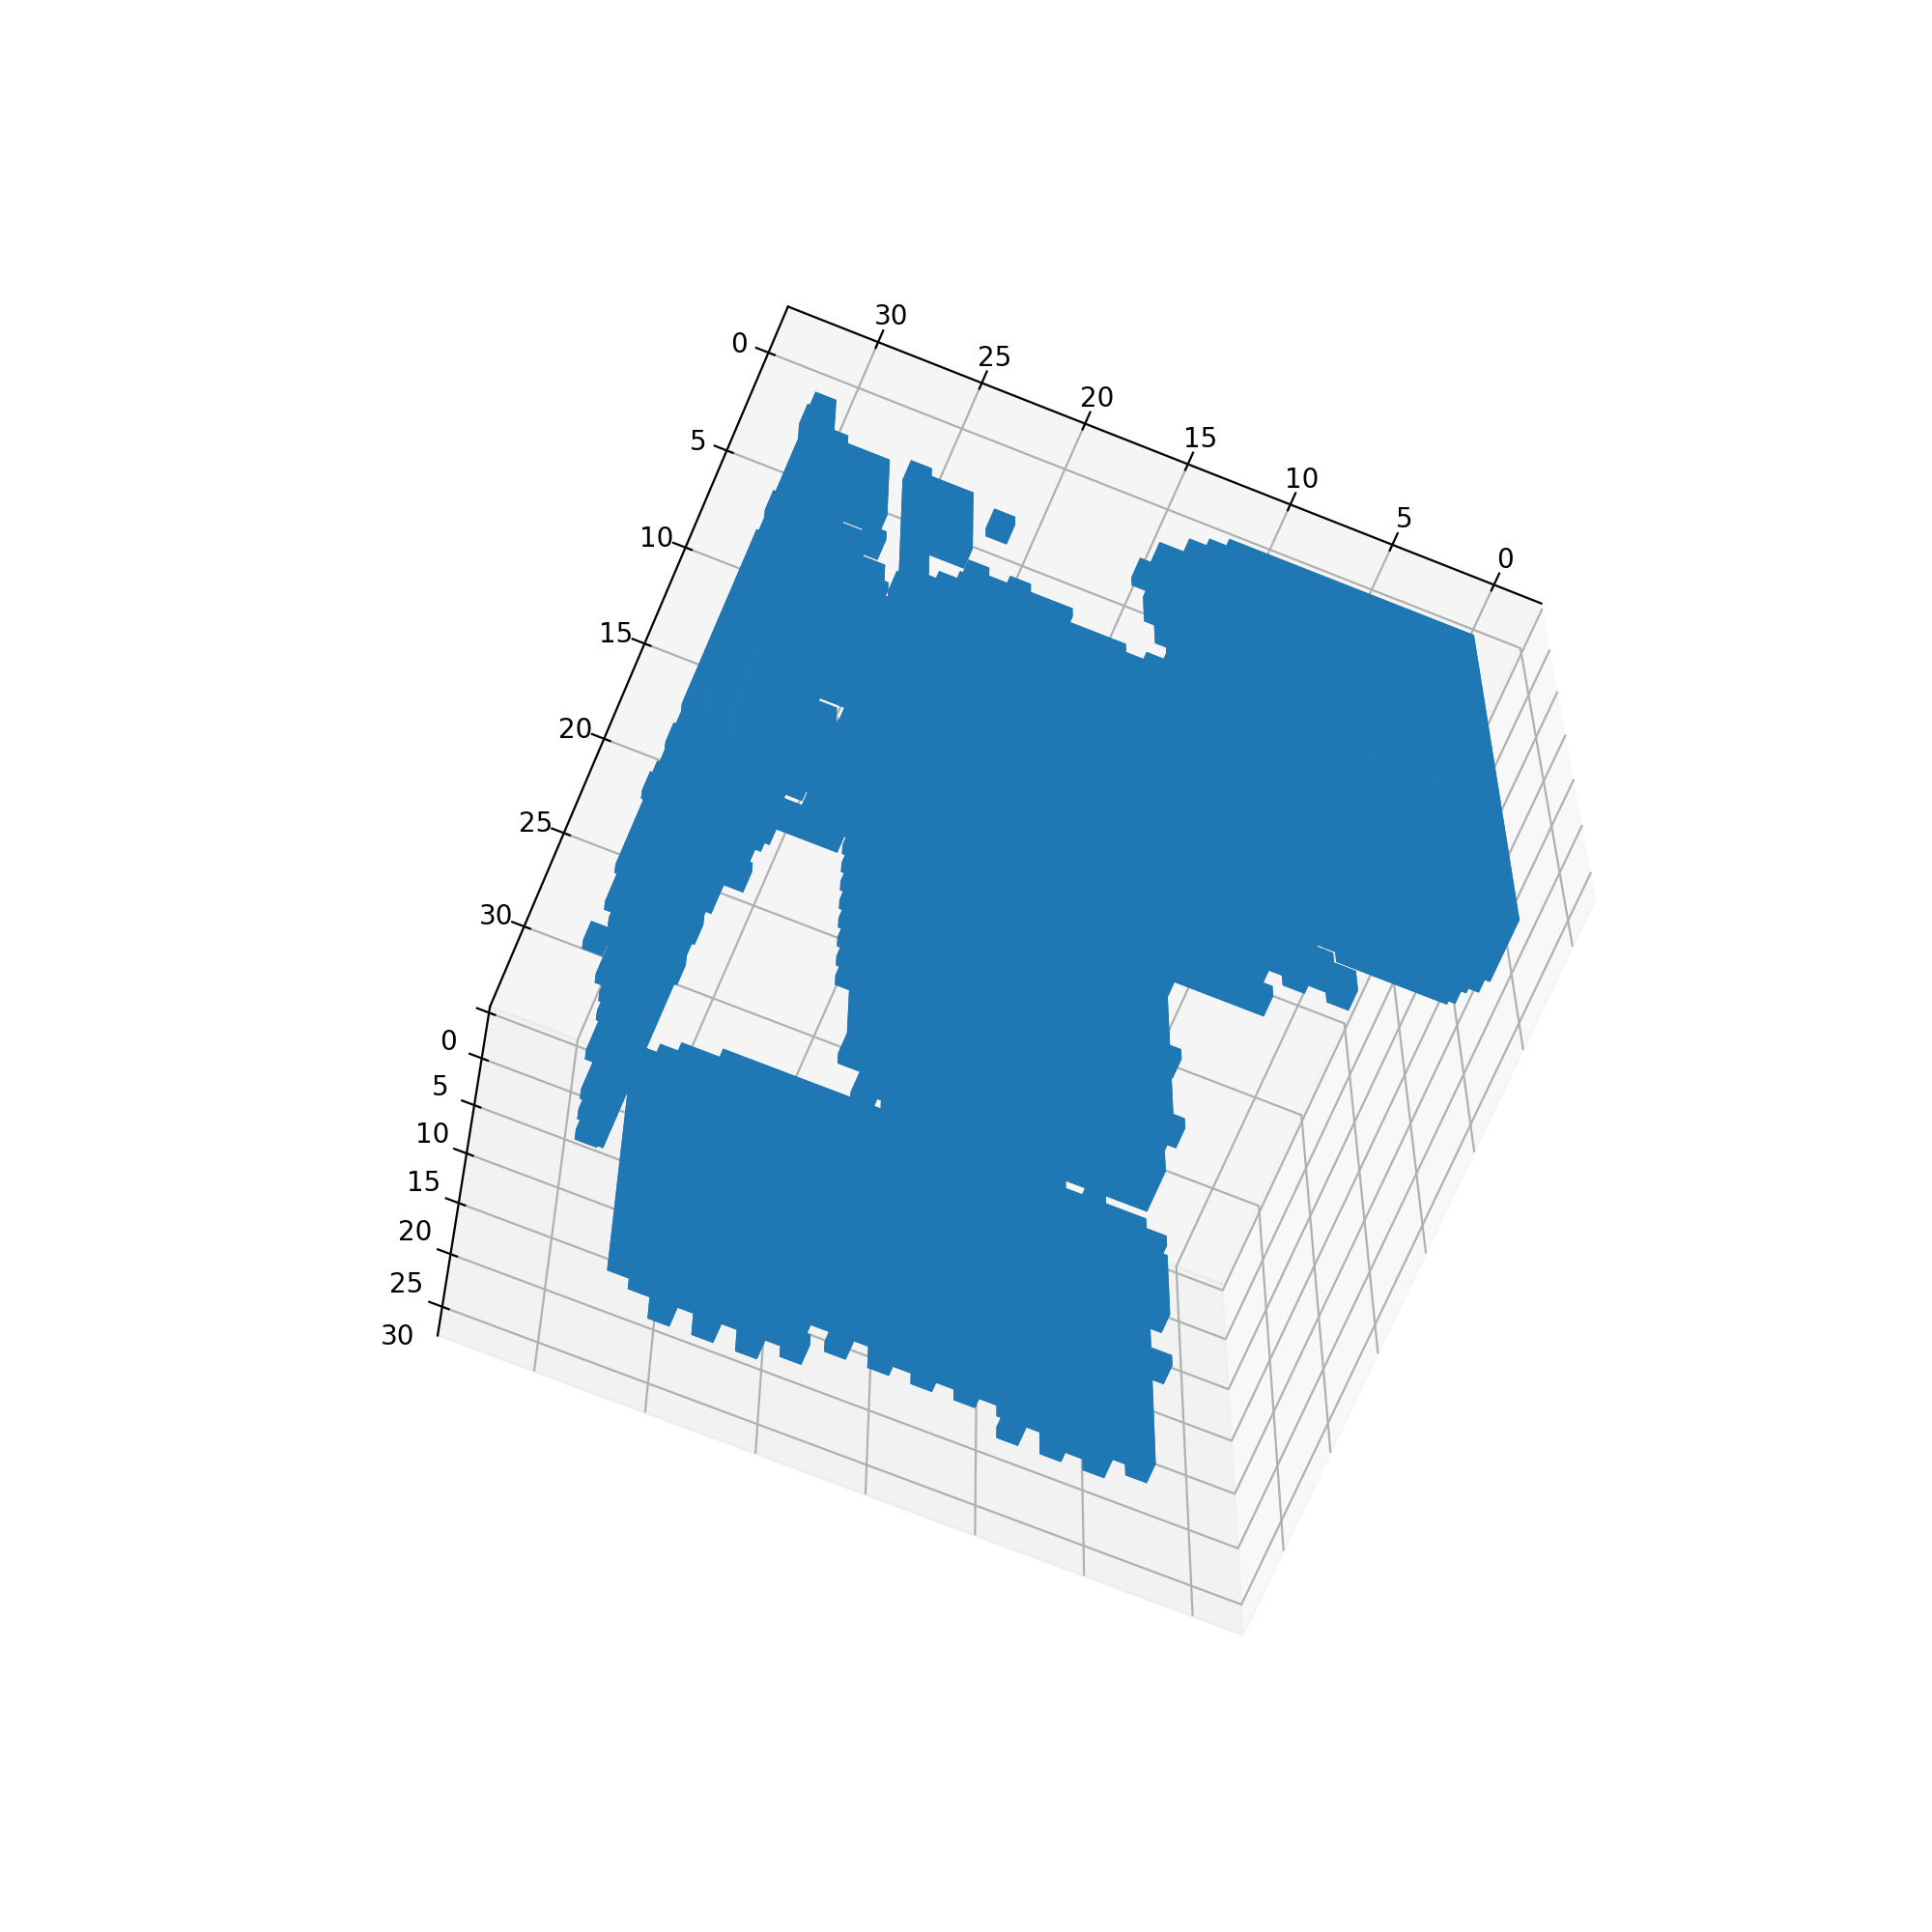

In [28]:
voxels = np.array(test_visualisation.data)

# and plot everything
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.voxels(voxels)
fig.savefig('VoxelizedFinal.png')
fig.show()

In [ ]:
'''def summary(input_size, model):
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split('.')[-1].split("'")[0]
                module_idx = len(summary)

                m_key = '%s-%i' % (class_name, module_idx+1)
                summary[m_key] = OrderedDict()
                summary[m_key]['input_shape'] = list(input[0].size())
                summary[m_key]['input_shape'][0] = -1
                summary[m_key]['output_shape'] = list(output.size())
                summary[m_key]['output_shape'][0] = -1

                params = 0
                if hasattr(module, 'weight'):
                    params += th.prod(th.LongTensor(list(module.weight.size())))
                    if module.weight.requires_grad:
                        summary[m_key]['trainable'] = True
                    else:
                        summary[m_key]['trainable'] = False
                if hasattr(module, 'bias'):
                    params +=  th.prod(th.LongTensor(list(module.bias.size())))
                summary[m_key]['nb_params'] = params
                
            if not isinstance(module, nn.Sequential) and \
               not isinstance(module, nn.ModuleList) and \
               not (module == model):
                hooks.append(module.register_forward_hook(hook))
                
        dtype = th.cuda.FloatTensor
        
        # check if there are multiple inputs to the network
        if isinstance(input_size[0], (list, tuple)):
            x = [Variable(th.rand(1,*in_size)).type(dtype) for in_size in input_size]
        else:
            x = Variable(th.rand(1,*input_size)).type(dtype)
            
        print(x.shape)
        print(type(x[0]))
        # create properties
        summary = OrderedDict()
        hooks = []
        # register hook
        model.apply(register_hook)
        # make a forward pass
        model(x)
        # remove these hooks
        for h in hooks:
            h.remove()

        print('----------------------------------------------------------------')
        line_new = '{:>20}  {:>25} {:>15}'.format('Layer (type)', 'Output Shpae', 'Param #')
        print(line_new)
        print('================================================================')
        total_params = 0
        trainable_params = 0
        for layer in summary:
            ## input_shape, output_shape, trainable, nb_params
            line_new = '{:>20}  {:>25} {:>15}'.format(layer, summary[layer]['output_shape'], summary[layer]['nb_params'])
            total_params += summary[layer]['nb_params']
            if 'trainable' in summary[layer]:
                if summary[layer]['trainable'] == True:
                    trainable_params += summary[layer]['nb_params']
            print(line_new)
        print('================================================================')
        print('Total params: ' + str(total_params))
        print('Trainable params: ' + str(trainable_params))
        print('Non-trainable params: ' + str(total_params - trainable_params))
        print('----------------------------------------------------------------')
        return summary'''